In [1]:
from utils import read_csv_data, clean_location

data = read_csv_data("../data/processed_job_postings_large_noNA.csv", 
                     ["industry", "work_type", "location", "formatted_experience_level",
                      "name", "cleaned_title", "cleaned_description", "title_emb"],
                     "salary_level")
data = clean_location(data, 2)
import random
random.seed(42)
random.shuffle(data)

train_data = data[:10000]
val_data = data[10000:13000]
test_data = data[13000:]

In [2]:
from utils import build_column_vocabulary

vocab_industry = build_column_vocabulary(train_data, 0)
vocab_type = build_column_vocabulary(train_data, 1)
vocab_state = build_column_vocabulary(train_data, 2)
vocab_level = build_column_vocabulary(train_data, 3)

In [3]:
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

targets = [data[i][1] for i in range(len(data))]

labels = ['10K-'] + [f"{i}K - {i + 10}K" for i in range(10, 150, 10)] + ['160K+']
label_to_int = {label: i for i, label in enumerate(labels)}

targets = list(map(lambda x: label_to_int[x], targets))

targets = torch.tensor(targets)

train_targets = targets[:10000]
val_targets = targets[10000:13000]
test_targets = targets[13000:]

In [4]:
torch.cuda.empty_cache()

In [5]:
from utils import convert_to_one_hot
import torch

train_cat_features = convert_to_one_hot(train_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

val_cat_features = convert_to_one_hot(val_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

test_cat_features = convert_to_one_hot(test_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert Lists to Tensors
train_cat_features = torch.stack(train_cat_features).to(device)
val_cat_features = torch.stack(val_cat_features).to(device)
test_cat_features = torch.stack(test_cat_features).to(device)

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right" 
a = tokenizer('hello this is a test',
         truncation=True,
         padding='max_length',
         max_length=512,
         return_tensors="pt")

In [7]:
from gpt1 import GPT1Dataset

semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in train_data]
input_ids_train, attention_mask_train = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids_train.append(encoding['input_ids'][0])
    attention_mask_train.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids_train = torch.stack(input_ids_train).to(device)
attention_mask_train = torch.stack(attention_mask_train).to(device)

labels = [target for target in train_targets]

train_dataset = GPT1Dataset(input_ids_train, attention_mask_train, train_cat_features, labels)

In [8]:
semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in val_data]
input_ids_val, attention_mask_val = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids_val.append(encoding['input_ids'][0])
    attention_mask_val.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids_val = torch.stack(input_ids_val).to(device)
attention_mask_val = torch.stack(attention_mask_val).to(device)

labels = [target for target in val_targets]

val_dataset = GPT1Dataset(input_ids_val, attention_mask_val, val_cat_features, labels)

In [9]:
semantic_items = [item[0][4] + ' ' + item[0][5] + ' ' + item[0][6] for item in test_data]
input_ids_test, attention_mask_test = [], []
for description in semantic_items:
    encoding = tokenizer(description,
                         truncation=True,
                         padding='max_length',
                         max_length=512,
                         return_tensors="pt")
    # input_ids.append(encoding['input_ids'].squeeze())
    # attention_mask.append(encoding['attention_mask'].squeeze())
    input_ids_test.append(encoding['input_ids'][0])
    attention_mask_test.append(encoding['attention_mask'][0])

# Convert Lists to Tensors
input_ids_test = torch.stack(input_ids_test).to(device)
attention_mask_test = torch.stack(attention_mask_test).to(device)

labels = [target for target in test_targets]

test_dataset = GPT1Dataset(input_ids_test, attention_mask_test, test_cat_features, labels)

Iter 50: Loss: 4.563137054443359 Train Acc: 0.13866666666666666, Validation Acc: 0.158
Iter 100: Loss: 2.701261281967163 Train Acc: 0.10066666666666667, Validation Acc: 0.11533333333333333
Iter 150: Loss: 2.9396495819091797 Train Acc: 0.13866666666666666, Validation Acc: 0.158
Iter 200: Loss: 2.6101791858673096 Train Acc: 0.09066666666666667, Validation Acc: 0.08866666666666667
Iter 250: Loss: 2.837296962738037 Train Acc: 0.11, Validation Acc: 0.094
Iter 300: Loss: 2.4487454891204834 Train Acc: 0.13866666666666666, Validation Acc: 0.15866666666666668
Iter 350: Loss: 2.430227041244507 Train Acc: 0.208, Validation Acc: 0.20866666666666667
Iter 400: Loss: 2.579683780670166 Train Acc: 0.21066666666666667, Validation Acc: 0.208
Iter 450: Loss: 2.511953592300415 Train Acc: 0.13933333333333334, Validation Acc: 0.15866666666666668
Iter 500: Loss: 2.4991726875305176 Train Acc: 0.168, Validation Acc: 0.17733333333333334
Iter 550: Loss: 3.0174825191497803 Train Acc: 0.18466666666666667, Validatio

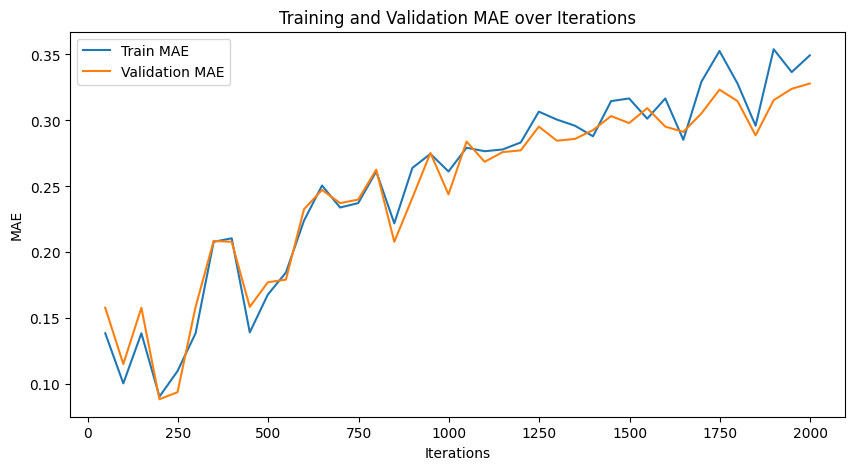

In [11]:
from bert import Bert
from gpt1 import train_classifier


model = Bert(len(vocab_type) + len(vocab_industry) + len(vocab_state) + len(vocab_level), output_size=len(labels), hidden_size=1000)
model.to(device)

# Note that the accuracy is calculated only on 1500 samples from both train and validation sets, not the entire dataset
# There are test on entire train/val/test set later
train_classifier(model, train_data=train_dataset, val_data=val_dataset, learning_rate=0.01, batch_size=25, num_epochs=5)

Iter 50: Loss: 1.9044713973999023 Train Acc: 0.30333333333333334, Validation Acc: 0.2986666666666667
Iter 100: Loss: 1.8588241338729858 Train Acc: 0.38066666666666665, Validation Acc: 0.3353333333333333
Iter 150: Loss: 1.8658338785171509 Train Acc: 0.36533333333333334, Validation Acc: 0.3313333333333333
Iter 200: Loss: 1.7411561012268066 Train Acc: 0.346, Validation Acc: 0.3293333333333333
Iter 250: Loss: 1.8390110731124878 Train Acc: 0.36666666666666664, Validation Acc: 0.352
Iter 300: Loss: 1.6274816989898682 Train Acc: 0.3606666666666667, Validation Acc: 0.32266666666666666
Iter 350: Loss: 1.7367972135543823 Train Acc: 0.38666666666666666, Validation Acc: 0.34
Iter 400: Loss: 1.6043422222137451 Train Acc: 0.37533333333333335, Validation Acc: 0.3313333333333333
Iter 450: Loss: 1.3470274209976196 Train Acc: 0.3913333333333333, Validation Acc: 0.35333333333333333
Iter 500: Loss: 1.9932743310928345 Train Acc: 0.316, Validation Acc: 0.302
Iter 550: Loss: 1.398637056350708 Train Acc: 0.36

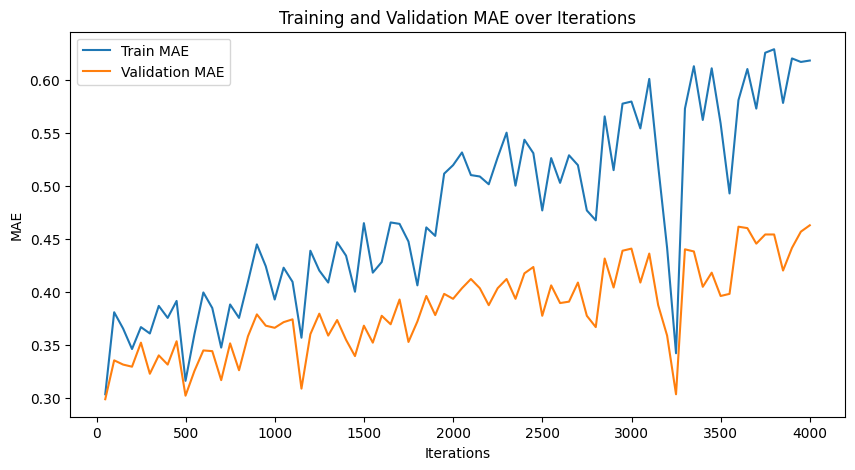

In [15]:
# Train more steps and see what happens
train_classifier(model, train_data=train_dataset, val_data=val_dataset, learning_rate=0.01, batch_size=25, num_epochs=10)

Iter 50: Loss: 0.9825387001037598 Train Acc: 0.6253333333333333, Validation Acc: 0.4493333333333333
Iter 100: Loss: 0.9004930257797241 Train Acc: 0.6633333333333333, Validation Acc: 0.48
Iter 150: Loss: 0.8007769584655762 Train Acc: 0.5933333333333334, Validation Acc: 0.4653333333333333
Iter 200: Loss: 1.238079309463501 Train Acc: 0.5753333333333334, Validation Acc: 0.426
Iter 250: Loss: 1.1163522005081177 Train Acc: 0.614, Validation Acc: 0.4646666666666667
Iter 300: Loss: 0.8921347856521606 Train Acc: 0.6433333333333333, Validation Acc: 0.468
Iter 350: Loss: 1.138890027999878 Train Acc: 0.658, Validation Acc: 0.502
Iter 400: Loss: 1.0060296058654785 Train Acc: 0.6753333333333333, Validation Acc: 0.48933333333333334
Iter 450: Loss: 1.1263785362243652 Train Acc: 0.6393333333333333, Validation Acc: 0.488
Iter 500: Loss: 1.3270387649536133 Train Acc: 0.688, Validation Acc: 0.49066666666666664
Iter 550: Loss: 0.7706208825111389 Train Acc: 0.6726666666666666, Validation Acc: 0.485333333333

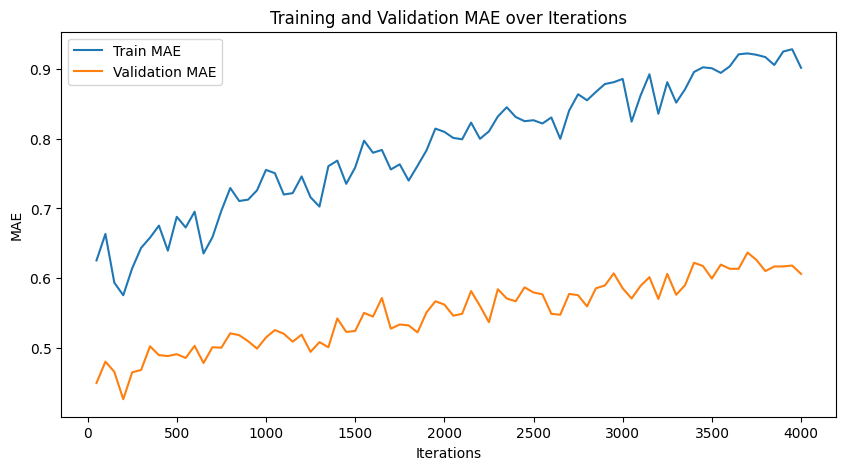

In [42]:
train_classifier(model, train_data=train_dataset, val_data=val_dataset, learning_rate=0.01, batch_size=25, num_epochs=10)

In [43]:
# Copied code to calculate accuracy
from torch.utils.data import DataLoader

def _collate_batch(batch):
    """Custom collate function for handling batches of data where all input tensors are of the same length."""

    # Separate and stack the data directly since all tensors are already of the same length
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    categorical_features = torch.stack([item['categorical_features'] for item in batch]).float()
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.float).to(device)

    return input_ids, attention_mask, categorical_features, labels

def calculate_accuracy(model, dataloader: DataLoader) -> float:
    """
    Calculate the accuracy for a model over a given dataloader.

    Args:
        model: The model to evaluate.
        dataloader (DataLoader): The DataLoader containing the dataset.

    Returns:
        float: The accuracy of the model.
    """
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for input_ids, attention_mask, categorical_features, labels in dataloader:
            outputs = model(input_ids, attention_mask, categorical_features)
            outputs = outputs.squeeze()  # Adjust shape if necessary

            predictions = torch.argmax(outputs, dim=1)
            total_correct += torch.sum(predictions == labels).item()
            total_count += labels.size(0)
        return total_correct / total_count

In [44]:
# Accuracy of Base Bert Model without title_emb
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
print(f"Model train accuracy: {calculate_accuracy(model, train_loader)}")
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
print(f"Model val accuracy: {calculate_accuracy(model, val_loader)}")
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=True, collate_fn=_collate_batch)
print(f"Model test accuracy: {calculate_accuracy(model, test_loader)}")

Model train accuracy: 0.9069
Model val accuracy: 0.6233333333333333
Model test accuracy: 0.6036916395222585


In [14]:
from bert import Bert
from gpt1 import train_classifier
model2 = Bert(len(vocab_type) + len(vocab_industry) + len(vocab_state) + len(vocab_level), 
              output_size=len(labels), hidden_size=1000, fine_tune=False)

model2.to(device)

train_classifier(model2, train_data=train_dataset, val_data=val_dataset, learning_rate=0.05, batch_size=200, num_epochs=10)

Iter 50: Loss: 6.47158145904541 Train Acc: 0.141875, Validation Acc: 0.15625
Iter 100: Loss: 3.6665279865264893 Train Acc: 0.1375, Validation Acc: 0.1575
Iter 150: Loss: 2.723903179168701 Train Acc: 0.12875, Validation Acc: 0.131875


KeyboardInterrupt: 

In [35]:
# Concat title_emb to the input of the model and check performance
from utils import cat_emb
train_cat_features = convert_to_one_hot(train_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])
train_cat_features_with_emb = cat_emb(train_cat_features, train_data, 7)

val_cat_features = convert_to_one_hot(val_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])
val_cat_features_with_emb = cat_emb(val_cat_features, val_data, 7)

test_cat_features = convert_to_one_hot(test_data, 
                                  [(0, vocab_industry),
                                   (1, vocab_type),
                                   (2, vocab_state),
                                   (3, vocab_level)])
test_cat_features_with_emb = cat_emb(test_cat_features, test_data, 7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert Lists to Tensors
train_cat_features_with_emb = torch.stack(train_cat_features_with_emb).to(device)
val_cat_features_with_emb = torch.stack(val_cat_features_with_emb).to(device)
test_cat_features_with_emb = torch.stack(test_cat_features_with_emb).to(device)


In [40]:
val_cat_features_with_emb.shape[0]

3000

In [37]:
train_dataset_with_emb = GPT1Dataset(input_ids_train, attention_mask_train, train_cat_features_with_emb, labels)
val_dataset_with_emb = GPT1Dataset(input_ids_val, attention_mask_val, val_cat_features_with_emb, labels)
test_dataset_with_emb = GPT1Dataset(input_ids_test, attention_mask_test, test_cat_features_with_emb, labels)

In [38]:
train_cat_features_with_emb.shape

torch.Size([10000, 655])

Iter 50: Loss: 5.417140007019043 Train Acc: 0.1487513572204126, Validation Acc: 0.1487513572204126
Iter 100: Loss: 2.7171106338500977 Train Acc: 0.09011943539630836, Validation Acc: 0.08577633007600434
Iter 150: Loss: 2.8977975845336914 Train Acc: 0.10206297502714441, Validation Acc: 0.10749185667752444
Iter 200: Loss: 2.6037306785583496 Train Acc: 0.09554831704668838, Validation Acc: 0.09554831704668838
Iter 250: Loss: 2.282376766204834 Train Acc: 0.1487513572204126, Validation Acc: 0.1487513572204126
Iter 300: Loss: 2.4819440841674805 Train Acc: 0.08034744842562432, Validation Acc: 0.0781758957654723
Iter 350: Loss: 2.526681900024414 Train Acc: 0.1487513572204126, Validation Acc: 0.1487513572204126


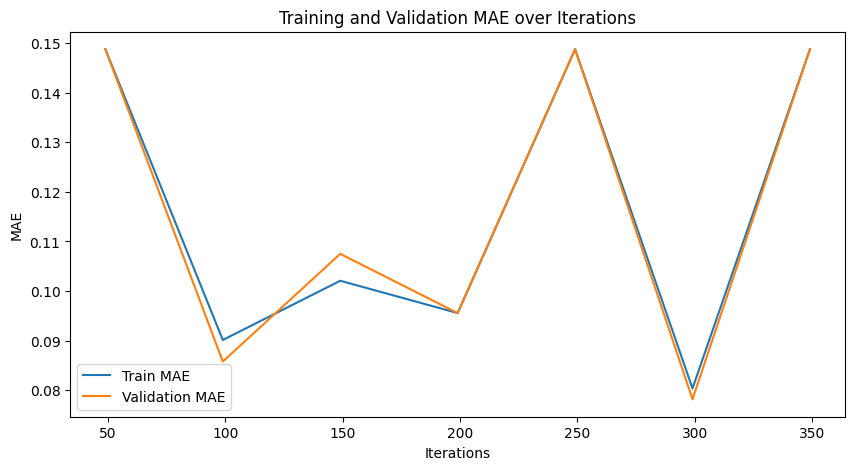

In [41]:
model2 = Bert(val_cat_features_with_emb.shape[1], output_size=len(labels), hidden_size=1000)
model2.to(device)

train_classifier(model2, train_data=train_dataset_with_emb, val_data=val_dataset_with_emb, 
                 learning_rate=0.01, batch_size=25, num_epochs=10)

In [24]:
torch.cuda.empty_cache()